In [1]:
import matplotlib.pyplot as plt
import numpy as np
import signac

from cmeutils.sampling import is_equilibrated

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************



In [2]:
project = signac.get_project()

In [3]:
# We don't want to include the shrinking portion of the trajectory's data
shrink_cut = 5000

for job in project.find_jobs():
    if job.doc.runs == 0: # Don't try to test for jobs that haven't finished their initial run
        continue
    log = np.genfromtxt(job.fn(f"log{job.doc.runs - 1}.txt"), names=True)
    pe = log["mdcomputeThermodynamicQuantitiespotential_energy"]
    # equil: bool (True or False), t0: int (starting data point that you can sample from), neff: number of data points in equilibrated region
    equil, t0, g, neff = is_equilibrated(data=pe[shrink_cut:], threshold_neff=200) 
    if equil:
        # Update the job's document file
        # We want job.doc to be True to signal the "production" signac operation in project.py the next time we submit this job
        job.doc.equilibrated = True
        job.doc.t0 = t0 + shrink_cut
        job.doc.neff = neff
        job.doc.equil_run = job.doc.runs - 1
    else:
        # If it's not equilibrated, job.doc.equilibrated stays false, and the "run-longer" operation in project.py will run next time we submit this job
        print(job.id)
        print(t0, g, neff)
        print()

/home/chrisjones4/miniconda3/envs/entanglements/lib/python3.11/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


/tmp/ipykernel_547102/1706735636.py:5: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(pe[job.doc.t0:] / job.doc.n_particles, label=job.sp.chains)


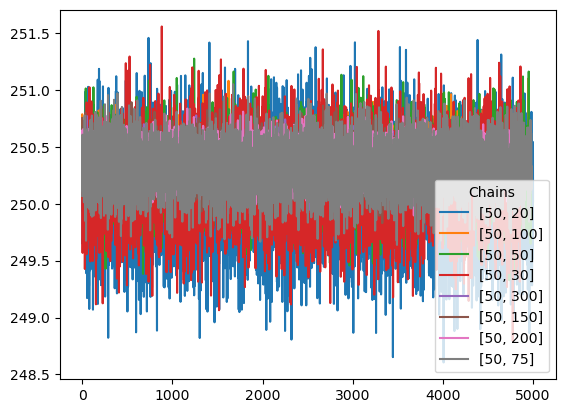

In [4]:
# Plot the PE for the equilibrated jobs as an extra sanity check. Do they look equilibrated?
for job in project.find_jobs(filter={"doc.equilibrated": True}):
    log = np.genfromtxt(job.fn(f"log{job.doc.equil_run}.txt"), names=True)
    pe = log["mdcomputeThermodynamicQuantitiespotential_energy"]
    plt.plot(pe[job.doc.t0:] / job.doc.n_particles, label=job.sp.chains)

plt.legend(title="Chains")